## Final Project Submission

Please fill out:
* Student name: Andrew Levinton
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Ahbineet Kulkarni
* Blog post URL:


## Statsmodels debug
- This is because statsmodels was having version issues. this is a workaround
- The code below re-publishes the existing (but private) _centered function as a public attribute to the module already imported in RAM.

In [155]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

## Import necessary libraries

In [156]:
# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# data visualiztion
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pywaffle import Waffle
import squarify

plt.style.use('fivethirtyeight')

# regression modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols

# model validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

import squarify

plt.style.use('fivethirtyeight')

In [157]:
# returns OLS linear regression model
def run_OLS_model(X,y):

    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()

    return model

In [158]:
cd data

[WinError 2] The system cannot find the file specified: 'data'
C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_2\Phase_2_Project\dsc-phase-2-project-v2-5\data


The data set used in this analysis is open-source data available directly from Kings County's website (https://kingcounty.gov/services/data.aspx). This particular data set covers various aspects of realestate transactions including date of sale, square footage of house and lot, proximity to recreational and natural resources, etc.

The initial data set used contains 30155 total records. The dataset starts with 24 total features (i.e. columns), only 


 Edit: 
 ### 8 of which are ultimately included in the final model aslo with 6 additional features inferred from the original data (e.g. one-hot encoding).###

## Read in dataset

In [159]:
df = pd.read_csv('kc_house_data.csv')
len(df), df.shape

(30155, (30155, 25))

# Data Preparation

In [160]:
df.isnull().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

Null values and non-numerical values are then re-encoded so that all values in the data set are numerical with no missing values. The details of how this is achieved for each data feature is explained in the comments below.

In [161]:
# Changing grade to a float
df['grade'] = df['grade'].apply(lambda x: float(x.split(' ')[0]))

# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
df.condition.replace(to_replace=condition_dict,inplace=True)

# replace yr_built NaNs with numeric 0
df.yr_renovated.replace(to_replace=np.nan,value=0,inplace=True)

# convert waterfront into numeric boolean
waterfront_bool_dict = {'YES':1,'NO':0,np.nan:0}
df.waterfront.replace(to_replace=waterfront_bool_dict,inplace=True)

# convert view from string into categorical ordinal
view_dict = {np.nan:0,'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
df.view.replace(to_replace=view_dict,inplace=True)

# convert dates into ordinals, extrapolate month from date into new column. 
df.date = pd.to_datetime(df['date']) # convert date string into datetime object 
df['sale_month'] = df['date'].dt.month # extropolate month from date into new column
df.date = df['date'].map(dt.datetime.toordinal) # convert original date to ordinal
df.rename({'date':'sale_date'},axis=1,inplace=True) # rename date to 'sale_date' for readability 


In [162]:
df.dtypes

id                 int64
sale_date          int64
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
greenbelt         object
nuisance          object
view               int64
condition          int64
grade            float64
heat_source       object
sewer_system      object
sqft_above         int64
sqft_basement      int64
sqft_garage        int64
sqft_patio         int64
yr_built           int64
yr_renovated       int64
address           object
lat              float64
long             float64
sale_month         int64
dtype: object

## Eliminating outliers

For this analysis an outlier is considered any record where the target variable (price) is greater than 3 standard deviations from the target variable mean.

In [165]:
std_thresh = df.price.std()*3 # value of the third central moment of the target variable
outlier_eliminated_df = df.loc[abs(df['price']) <= std_thresh] # slicing all data within the defined range

# assign X and y variables to the appropriate dataframes/series
y = outlier_eliminated_df.price
X_outliers_eliminated = outlier_eliminated_df.drop('price',axis=1)

## Print columns to begin search for predictors

In [97]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

## Check for correlations vs price for numerical variables

In [98]:
df.corr().sort_values('price',ascending=False)['price'].abs()

price            1.000000
sqft_living      0.608521
grade            0.565263
sqft_above       0.538651
bathrooms        0.480401
sqft_patio       0.313409
bedrooms         0.289204
sqft_garage      0.264169
sqft_basement    0.245058
floors           0.180576
yr_built         0.096013
sqft_lot         0.085730
yr_renovated     0.084786
lat              0.063632
long             0.022509
id               0.034184
Name: price, dtype: float64

## Looking at log transformations for the price.

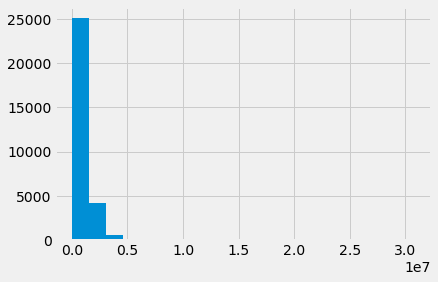

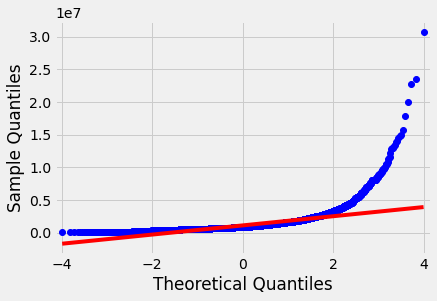

In [167]:
df['price'].hist(bins=20);

sm.graphics.qqplot(df['price'],line='r');

As shown by the histogram of the price, we have a distribution that is heavily skewed right. The QQplot shows that the price follows an exponential pattern.

## Using log transformation to normally distribute the price data

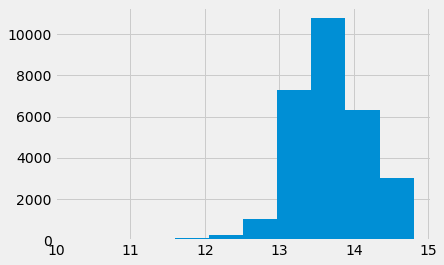

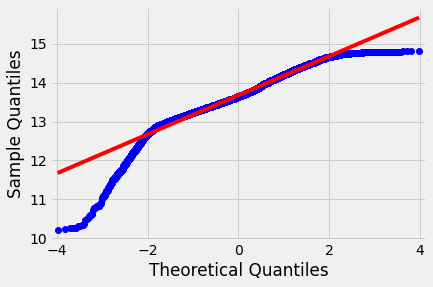

In [168]:
y_log = np.log(y)

y_log.hist();
sm.qqplot(y_log, line='r');

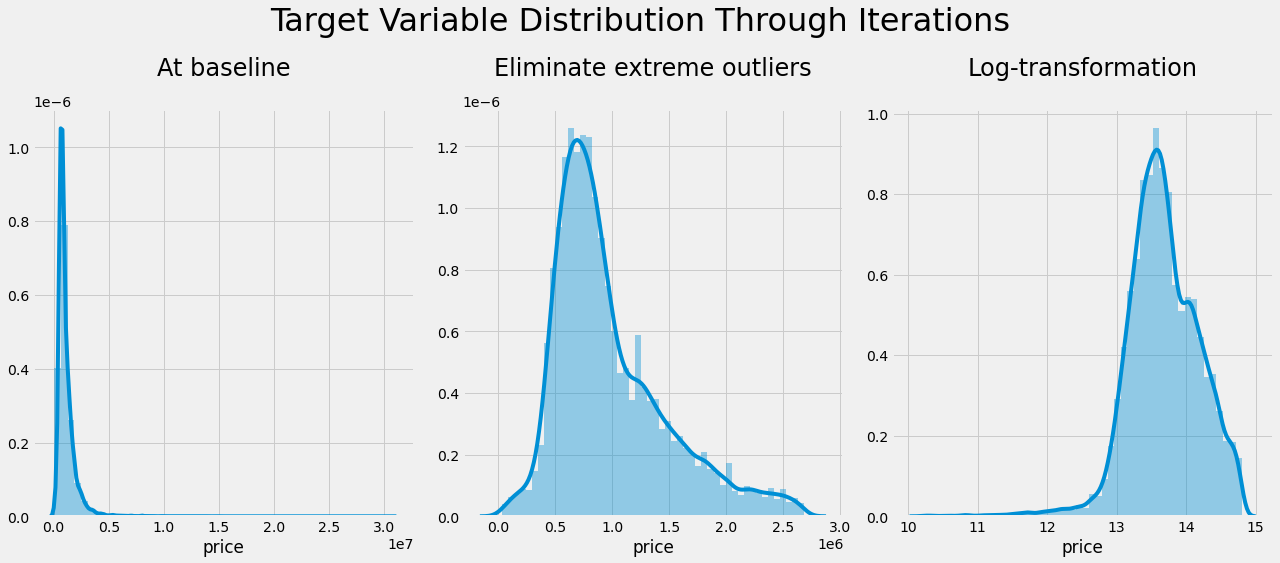

In [169]:

fig, (ax1,ax2,ax3) = plt.subplots(1,3)

og = sns.distplot(df['price'],ax=ax1).set_title('At baseline\n',fontsize=24)
ot = sns.distplot(y,ax=ax2).set_title('Eliminate extreme outliers\n',fontsize=24)
lo = sns.distplot(y_log,ax=ax3).set_title('Log-transformation\n',fontsize=24)

ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")


plt.gcf().set_size_inches(18, 8)
plt.suptitle("Target Variable Distribution Through Iterations",fontsize=32)
fig.tight_layout()
plt.show()

At this point the model was strong, the set of features was somewhat limited. The 'address' feature also still remained and was essentially uninterpretable due to the fact that it is not only categorical but nominal in nature. The next succesfuly better iteration was to extrapolate the proximity of a particular waterfront from the address feature, and then one-hot encoding each waterfront location. The details of how this was performed is outlined below.

Not much changes in terms of the correlations or the variables in order of correlation. We will look at the sqft_living aka Square footage of living space in the home as our first interesting variable based on the highest correlation. 

## Checking distribution of predictor

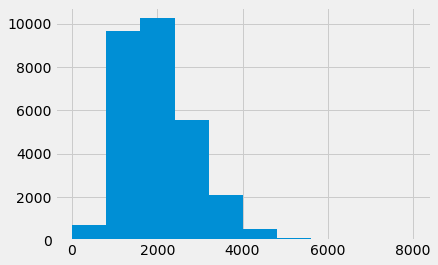

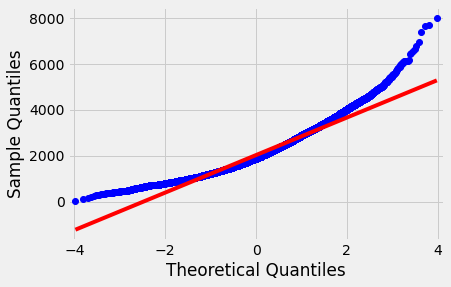

In [172]:
X_outliers_eliminated['sqft_living'].hist();
sm.qqplot(X_outliers_eliminated['sqft_living'], line='r');

Data is clearly skewed right and follows an exponential pattern similar to price. For this, we will use a logarithmic transformation.

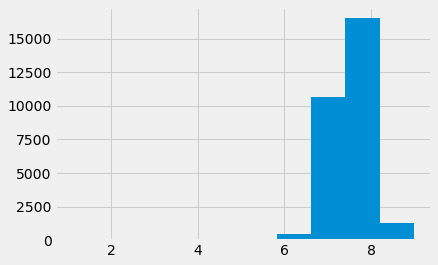

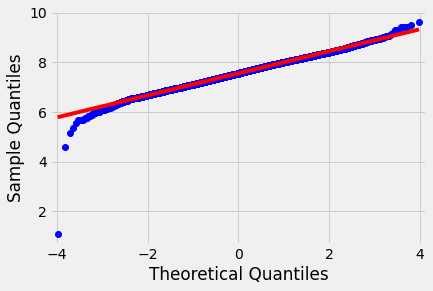

In [173]:
X_outliers_eliminated['sqft_living_log'] = np.log(X_outliers_eliminated['sqft_living'])
X_outliers_eliminated['sqft_living_log'].hist();
sm.qqplot(df['sqft_living_log'], line='r');

Sqft_living now shows an almost perfectly linear qqplot with the logarithmic transformation.

Data appears to be more normally distributed and shows better results on the QQplot.

There does not appear to be any meaningful improvement, so we will stick with the log transformation

## Building Preliminary model using the transformed sqft_living variable

In [187]:
X_outliers_eliminated['view']

0        0
1        2
2        2
3        2
4        0
        ..
30150    0
30151    1
30152    0
30153    0
30154    0
Name: view, Length: 28939, dtype: int64

In [190]:
X_outliers_eliminated['sqft_living_log*grade'] = X_outliers_eliminated['grade'] * X_outliers_eliminated['sqft_living_log']

In [191]:
X = X_outliers_eliminated[['sqft_living_log*grade','view']]
model = run_OLS_model(X,y_log)
residuals = model.resid

In [192]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     7972.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:39:12   Log-Likelihood:                -15277.
No. Observations:               28939   AIC:                         3.056e+04
Df Residuals:                   28936   BIC:                         3.058e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    12.0272      0.014    877.622      0.000      12.000      12.054
sqft_living_log*grade     0.0285      0.000    120.109      0.000       0.028       0.029
view                      0.0646      0.003     20.636      0.000       0.058       0.071
==============================================================================
Omnibus:                     8622.342   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70344.349
Skew:                          -1.204   Prob(JB):                         0.00
Kurtosis:                      10.248   Cond. No.                         331.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Preliminary model explains approximately 35.8% of the data according the the adjusted r-squared statistic. 
- sqft_living_log is a statistically significant variable as it shows a p-value under the 0.05 parameter

## Adding in new variables

Checking the correlations again to search for more numerical variables

In [136]:
df.corr()['price'].abs().sort_values(ascending=False)

price                      1.000000
price_8thrt                0.863631
sqft_living                0.608521
sqft_living_log * grade    0.606110
grade                      0.565263
sqft_above                 0.538651
sqft_living_4thrt          0.529183
sqft_living_log            0.514532
bathrooms                  0.480401
sqft_above_log             0.466467
sqft_patio                 0.313409
bedrooms                   0.289204
sqft_garage                0.264169
sqft_basement              0.245058
floors                     0.180576
yr_built                   0.096013
sqft_lot                   0.085730
yr_renovated               0.084786
lat                        0.063632
id                         0.034184
long                       0.022509
Name: price, dtype: float64

### Next variable to try will be the grade as it is on the next highest list for correlation
- Model will now have features consisting of the sqft_living_log variable and the grade against the same dependent variable.
- This will be known as X_NEW to avoid overlapping notation issues.
- Similarly, NEW_model and NEW_results will be the new defined names with the addition of the grade.

In [137]:
X_NEW = df[['sqft_living_log','grade']]
y = df['price']

NEW_model = sm.OLS(y, sm.add_constant(X_NEW))
NEW_results = NEW_model.fit()
print(NEW_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     8001.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:21:13   Log-Likelihood:            -4.4968e+05
No. Observations:               30155   AIC:                         8.994e+05
Df Residuals:                   30152   BIC:                         8.994e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4.829e+06   7.76e+04    -

In [111]:
r_squared_increase = str(round((NEW_results.rsquared - results_baseline.rsquared) * 100, 1)) + '%'
r_squared_increase

'8.3%'

 - NEW model explains approximately 44.1% of the data according the the adjusted r-squared statistic.
 - sqft_living_log is a statistically significant variable as it shows a p-value under the 0.05 parameter
 - grade is a statistically significant variable as it shows a p-value under the 0.05 parameter
 - Addition of the grade as an independent variable increased the model adj. r-squared by 8.3%

## The next numerical variable to look at is the sqft_above aka Square footage of house apart from basement. 
- All new names will be repeated as we are adding in new numerical variables to see if they improve the model. 
- First we will look at the distribution of the sqft_above. 

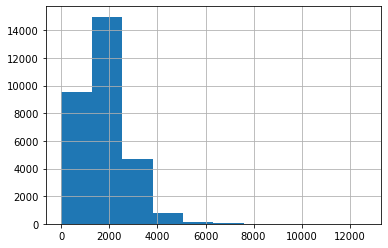

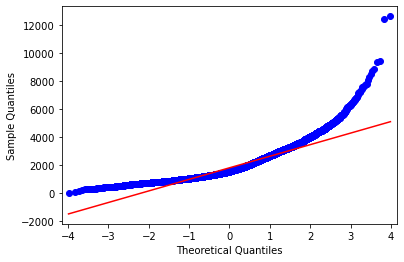

In [112]:
df['sqft_above'].hist();
sm.qqplot(df['sqft_above'], line='r');

### Similar to the sqft_living variable, data appears skewed left and should be transformed before being added to the model. 
- First "try" will be a log transformation, followed again by a root transformation. 

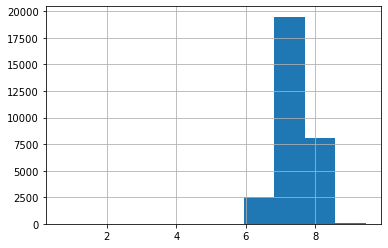

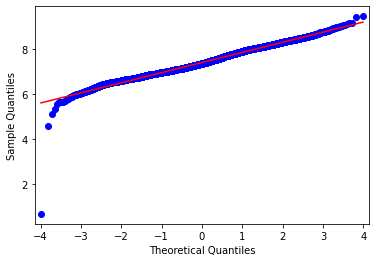

In [113]:
df['sqft_above_log'] = np.log(df['sqft_above'])

df['sqft_above_log'].hist();
sm.qqplot(df['sqft_above_log'], line='r');

Similarly as before with the sqft_living variable, the log transformation appears to be normally distributed now. Time to add the variable to the model to see if it improves. 

In [138]:
X_NEW = df[['sqft_living_log','grade', 'sqft_above_log']]
y = df['price']

NEW_model = sm.OLS(y, sm.add_constant(X_NEW))
NEW_results = NEW_model.fit()
print(NEW_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     5349.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:21:23   Log-Likelihood:            -4.4966e+05
No. Observations:               30155   AIC:                         8.993e+05
Df Residuals:                   30151   BIC:                         8.994e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4.721e+06   8.01e+04    -

No meaningful change has been made to the model with the sqft_above variable being added, so it will be left out. Time to look at the other numerical variables to see if any of them can possibly be used to add to the model itself. 

<Figure size 720x576 with 0 Axes>

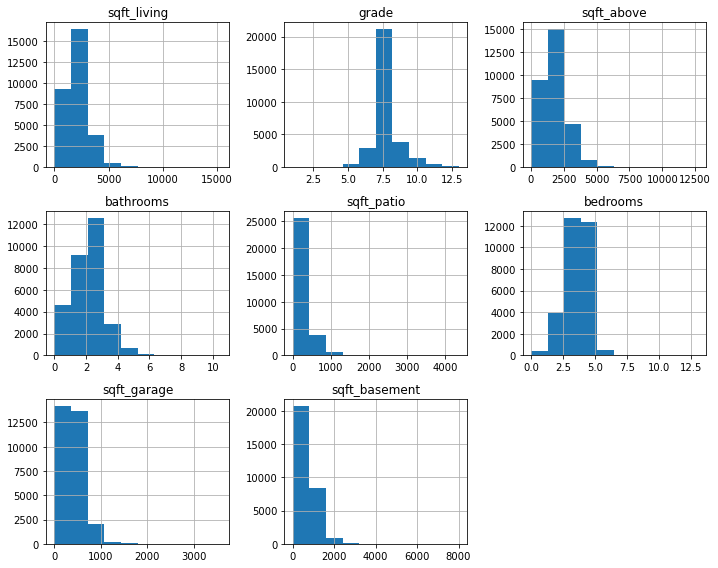

In [115]:
numerical_candidates = df[['sqft_living','grade','sqft_above','bathrooms','sqft_patio','bedrooms',\
                           'sqft_garage','sqft_basement']]
plt.figure(figsize=(10,8))
numerical_candidates.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

Since the sqft_above variable follows the same distribution as the sqft_living variable, it stands to reason that adding in other numerical variables with a similar distribution will also not improve the model. The only variable that does NOT appear to be skewed right along with the rest of the data is the bedrooms. This is the last numerical variable we will test. 

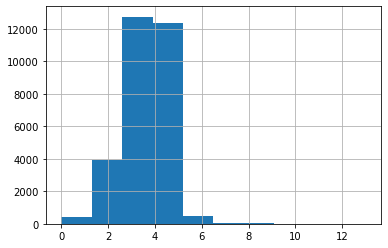

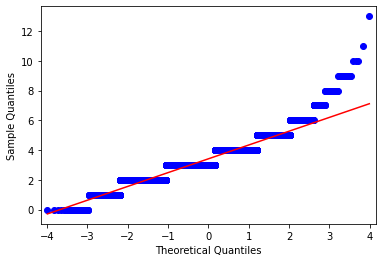

In [116]:
df['bedrooms'].hist();
sm.qqplot(df['bedrooms'], line='r');

In [139]:
X_NEW = df[['sqft_living_log','grade', 'bedrooms']]
y = df['price']

NEW_model = sm.OLS(y, sm.add_constant(X_NEW))
NEW_results = NEW_model.fit()
print(NEW_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     5352.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:21:32   Log-Likelihood:            -4.4966e+05
No. Observations:               30155   AIC:                         8.993e+05
Df Residuals:                   30151   BIC:                         8.994e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -5.147e+06   9.44e+04    -

Once again, bedrooms as an added variable does not improve the rsquared in the model, so it will be left out. This ends our exploration of the numerical variables!

## Attempting an interaction of the sqft_living_log and grade variable to improve model

In [118]:
df['sqft_living_log * grade'] = df['sqft_living_log'] * df['grade']

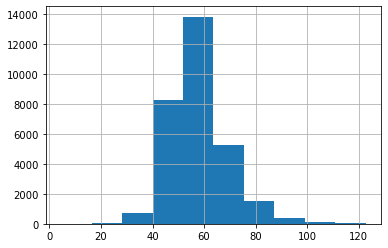

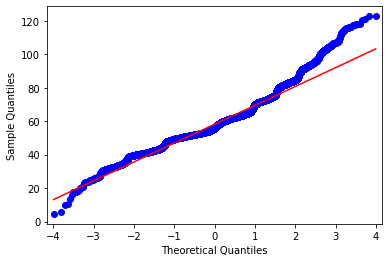

In [119]:
df['sqft_living_log * grade'].hist();
sm.qqplot(df['sqft_living_log * grade'], line='r');

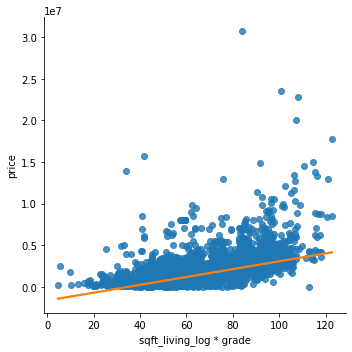

In [140]:
sns.lmplot(x ='sqft_living_log * grade', y ='price', data = df, line_kws={"color": "C1"})

- This interaction creates an almost perfectly linear plot. 

In [31]:
df['price_8thrt'].corr(df['sqft_living_log * grade'])

0.6664976892134773

In [143]:
X_NEW = df[['sqft_living_log * grade']]
y = df['price']

NEW_model = sm.OLS(y, sm.add_constant(X_NEW))
NEW_results = NEW_model.fit()
print(NEW_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                 1.751e+04
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:22:10   Log-Likelihood:            -4.4919e+05
No. Observations:               30155   AIC:                         8.984e+05
Df Residuals:                   30153   BIC:                         8.984e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1

# Adding in Categorical variables

In [33]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'price_8thrt',
       'sqft_living_log', 'sqft_living_4thrt', 'sqft_above_log',
       'sqft_living_log * grade'],
      dtype='object')

## Getting categorical candidates

In [48]:
categorical_candidates = df[['date','bathrooms','bedrooms','floors','waterfront','greenbelt',\
                             'nuisance','view','condition','grade','heat_source','sewer_system',\
                             'yr_renovated','address','lat','long']]


In [49]:
categorical_candidates_price = pd.concat([categorical_candidates, df['price_8thrt']], axis='columns')

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

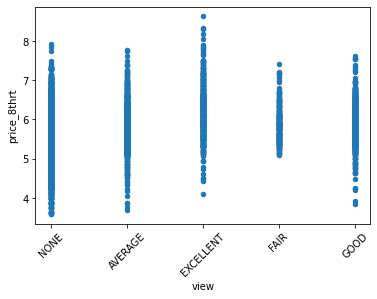

In [50]:
categorical_candidates_price['view'] = categorical_candidates_price['view'].astype(str)
categorical_candidates_price.plot.scatter(x='view',y='price_8thrt')
plt.xticks(rotation=45)

In [126]:
dummies = pd.get_dummies(df[['view']])

In [127]:
df_ = pd.concat([df,dummies],axis='columns')

In [130]:
df_.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'price_8thrt',
       'sqft_living_log', 'sqft_living_4thrt', 'sqft_above_log',
       'sqft_living_log * grade', 'view_AVERAGE', 'view_EXCELLENT',
       'view_FAIR', 'view_GOOD', 'view_NONE'],
      dtype='object')

In [144]:
X_final = df_[['sqft_living_log * grade','view_EXCELLENT','view_FAIR','view_GOOD','view_AVERAGE']]

final_model = sm.OLS(y, sm.add_constant(X_final))
final_results = model.fit()
print(final_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                 1.086e+04
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:22:21   Log-Likelihood:            -4.5146e+05
No. Observations:               30155   AIC:                         9.029e+05
Df Residuals:                   30153   BIC:                         9.029e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -6.741e+06   7.55e+04    -

In [133]:
r_squared_increase = str(round((final_results.rsquared - NEW_results.rsquared) * 100, 1)) + '%'
r_squared_increase

'3.8%'

- Final model explains approximately 47.9% of the data according the the adjusted r-squared statistic.
- sqft_living_log is a statistically significant variable as it shows a p-value under the 0.05 parameter
- grade is a statistically significant variable as it shows a p-value under the 0.05 parameter
- view_EXCELLENT is a statistically significant variable as it shows a p-value under the 0.05 parameter
- view_FAIR is a statistically significant variable as it shows a p-value under the 0.05 parameter
- view_GOOD is a statistically significant variable as it shows a p-value under the 0.05 parameter
- view_AVERAGE is a statistically significant variable as it shows a p-value under the 0.05 parameter
- Addition of the grade as an independent variable increased the model adj. r-squared by 3.8%